## package install/import

In [2]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/GraLSP_pytorch-master')

Mounted at /content/drive/


In [3]:
!pip install pyvis networkx gensim node2vec scikit-learn torch torchvision torch-geometric networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
import torch
import networkx as nx
import numpy as np
import random
import copy
from tqdm import tqdm
import random
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

## Parser

In [5]:
class Config:
    def __init__(self):
        # change the dataset here
        self.dataset_name = "cora"
        self.path_length = 10
        self.num_paths = 100
        self.window_size = 6
        self.batch_size = 100
        self.neg_size = 8
        self.learning_rate = 0.002
        self.embedding_dims = 32
        self.epochs = 1
        self.num_skips = 5
        self.num_neighbor = 20
        self.hidden_dim = 100
        self.walk_dim = 30
        self.anonym_walk_len = 8
        self.walk_loss_lambda = 0.1
        self.linkpred_ratio = 0.1
        self.p = 0.25
        self.q = 1
        self.inductive = 0
        self.inductive_model_epoch = None
        self.inductive_model_name = None
        self.save_path = "embeddings/GraLSP"
        self.radius = 2


## Util

In [12]:


parser = Config()

def get_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return device

def get_edge_list(parser):
    edge_list = []
    print(parser.dataset_name)
    with open("data/" + parser.dataset_name + "/edges", 'r') as f:
        for line in f:
            elems = line.rstrip().split(' ')
            src, dst = int(elems[0]), int(elems[1])
            if src == dst:
                continue
            edge_list.append((src, dst))
    num_nodes = 1 + max(max([u[0] for u in edge_list]), max([u[1] for u in edge_list]))
    return edge_list, num_nodes

def edge_list2nx(edge_list, num_nodes):
    g = nx.Graph()

    for i in range(num_nodes):
        g.add_node(i)
    for i, j in edge_list:
        g.add_edge(i, j)
    return g

def to_anonym_walk(walk):
        num_app = 0
        apped = dict()
        anonym = []
        for node in walk:
            if node not in apped:
                num_app += 1
                apped[node] = num_app
            anonym.append(apped[node])

        return anonym

def generate_radius():
  # immediate neighbor
  if parser.radius == 1:
    return 1
  elif parser.radius ==2 or parser.p/parser.q > 2.0:
    return 2
  else:
    return parser.q//parser.p


def generate_node_walks_and_radius(num_nodes, node_walks):
    node_anonymous_walks = [[] for i in range(num_nodes)]
    node_walk_radius = [[] for i in range(num_nodes)]

    radius = generate_radius()
    for ws in range(num_nodes):
        for w in node_walks[ws]:  #
            node_anonymous_walks[ws].append(to_anonym_walk(w))
            # node_walk_radius[ws].append(int(2*parser.anonym_walk_len/len(np.unique(w[:10]))))
            node_walk_radius[ws].append(radius)
    return node_anonymous_walks, node_walk_radius


def preprocess_transition_prob(g, num_nodes):
    degree_seq_dict = dict(g.degree)
    degree_seq = [degree_seq_dict[i] for i in range(num_nodes)]
    alias_nodes = {}

    for node in g.nodes():
        normalized_probs = [1/degree_seq[node] for i in range(degree_seq[node])]
        alias_nodes[node] = alias_setup(normalized_probs)

    alias_edges = {}

    for edge in g.edges():
        alias_edges[edge] = get_alias_edge(g,edge[0], edge[1])
        alias_edges[(edge[1], edge[0])] = get_alias_edge(g, edge[1], edge[0])

    alias_nodes = alias_nodes
    alias_edges = alias_edges

    return alias_nodes, alias_edges


def get_alias_edge(g,src, dst):
    unnormalized_probs = []
    for dst_nbr in sorted(g.neighbors(dst)):
        if dst_nbr == src:
            unnormalized_probs.append(1/parser.p)
        elif g.has_edge(dst_nbr, src):
            unnormalized_probs.append(1)
        else:
            unnormalized_probs.append(1/parser.q)
    normalize_const = np.sum(unnormalized_probs)
    normalized_probs = [prob/normalize_const for prob in unnormalized_probs]

    return alias_setup(normalized_probs)


def generate_node2vec_walks(g, num_nodes,alias_nodes, alias_edges):
    random_walks = []
    nodes = list(range(num_nodes))
    for _ in tqdm(range(parser.num_paths)):
        random.shuffle(nodes)
        for node in nodes:
            walk = node2vec_walk(g, node,alias_nodes, alias_edges)
            random_walks.append(walk)

    node_walks = [[] for i in range(num_nodes)]

    for w in random_walks:
        node_walks[w[0]].append(w)
    return node_walks, random_walks


def node2vec_walk(g, begin_node,alias_nodes, alias_edges):
    walk = [begin_node]

    while(len(walk) < parser.path_length):
        cur = walk[-1]
        cur_neighbors = get_neighbor(g, cur)
        cur_neighbors = sorted(cur_neighbors)
        if len(cur_neighbors):
            if len(walk) == 1:

                abc = alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])

                walk.append(cur_neighbors[abc])
            else:
                prev = walk[-2]
                nextnode = cur_neighbors[alias_draw(alias_edges[(prev, cur)][0],
                    alias_edges[(prev, cur)][1])]
                walk.append(nextnode)
        else:
            break

    return walk


def get_neighbor(g, node):
    neighbor = [n for n in g.neighbors(node)]
    return neighbor

def alias_setup(probs):
    """
    https://www.cnblogs.com/shenxiaolin/p/9097478.html
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K).astype(int)
    smaller = []
    larger = []

    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) >0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()
        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q):
    K = len(J)
    kk = int(np.floor(np.random.rand()*K))
    if np.random.rand()<q[kk]:
        return kk
    else:
        return J[kk]


def generate_anonym_walks(length):

    anonymous_walks = []
    def generate_anonymous_walk(totlen, pre):
        if len(pre) == totlen:
            anonymous_walks.append(pre)
            return
        else:
            candidate = max(pre) + 1 # 2
            for i in range(1, candidate+1): # 1,2
                if i!= pre[-1]:
                    npre = copy.deepcopy(pre)
                    npre.append(i)  # 1,2
                    generate_anonymous_walk(totlen, npre) # [1,2], [1,2,1],[1,2,3],[1,2,3,1],[1,2,3,2],.....
    generate_anonymous_walk(length, [1])
    return anonymous_walks


def generate_walk2num_dict(length):
    anonym_walks = generate_anonym_walks(length)
    anonym_dict = dict()
    curid = 0
    for walk in anonym_walks:
        swalk = intlist_to_str(walk)
        anonym_dict[swalk] = curid
        curid += 1
    return anonym_dict

def intlist_to_str(lst):
    slst = [str(x) for x in lst]
    strlst = "".join(slst)
    return strlst


def process_anonym_distr(num_nodes, length, node_anonymous_walks):
    node_anonym_walktypes = np.zeros((num_nodes, parser.num_paths))
    anonym_walk_dict = generate_walk2num_dict(length)
    node_anonym_distr = np.zeros((num_nodes, len(anonym_walk_dict)))
    for n in range(num_nodes):
        for idxw in range(len(node_anonymous_walks[n])):
            w = node_anonymous_walks[n][idxw]
            strw = intlist_to_str(w[:length])
            wtype = anonym_walk_dict[strw]
            node_anonym_walktypes[n][idxw] = wtype
            node_anonym_distr[n][wtype] += 1
    node_anonym_distr /= parser.num_paths
    graph_anonym_distr = np.mean(node_anonym_distr, axis = 0)
    graph_anonym_std = np.std(node_anonym_distr, axis = 0)
    graph_anonym_std[np.where(graph_anonym_std == 0)] = 0.001

    return (node_anonym_distr - graph_anonym_distr)/graph_anonym_std, node_anonym_walktypes



def generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius):
    types_and_nodes = [[] for i in range(num_nodes)]
    for ws in range(num_nodes):
        for _ in range(parser.num_paths * parser.num_skips):
            wk = random.randint(0, parser.num_paths-1)

            types_and_nodes[ws].append([node_anonym_walktypes[ws][wk].astype(int), random.choice(node_walks[ws][wk][:node_walk_radius[ws][wk]])])
    types_and_nodes = np.array(types_and_nodes).astype(int)
    return types_and_nodes


def get_node2label(num_nodes):
    node2label = np.zeros((num_nodes))
    with open("data/" + parser.dataset_name + "/node2label") as infile:
        for line in infile:
            elems = line.rstrip().split(" ")
            node, label = int(elems[0]), int(elems[1])
            node2label[node] = label
    node2label = node2label.astype(int)
    return node2label




def draw_TSNE():
  embeddings = np.load('embeddings/GraLSP/cora/2500.npy')

  label_mapping = {
      0: 'Neural_Networks',
      1: 'Rule_Learning',
      2: 'Reinforcement_Learning',
      3: 'Probabilistic_Methods',
      4: 'Theory',
      5: 'Genetic_Algorithms',
      6: 'Case_Based'
  }
  labels = get_node2label(num_nodes)
  tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=600)
  tsne_results = tsne.fit_transform(embeddings)

  n_clusters = 7
  kmeans = KMeans(n_clusters=n_clusters)
  clusters = kmeans.fit_predict(tsne_results)
  silhouette_avg = silhouette_score(tsne_results, clusters)
  print(f"The average silhouette score for {n_clusters} clusters is: {silhouette_avg}")

  plt.figure(figsize=(10, 10))
  for label_id, label_name in label_mapping.items():
      indices = [i for i, label in enumerate(labels) if label == label_id]
      plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label_name)
  plt.title('t-SNE of Node Embeddings')
  plt.legend()
  plt.show()

def draw_loss(batch_losses, batch_link_loss, batch_walk_loss, micro, macro):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    axes[0].plot(batch_losses, label='Batch Losses')
    axes[0].plot(batch_link_loss, label='Batch Link Loss')
    axes[0].plot(batch_walk_loss, label='Batch Walk Loss')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Losses Over Time')
    axes[0].legend()

    axes[1].plot(micro, label='Micro F1 Score')
    axes[1].plot(macro, label='Macro F1 Score')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Score')
    axes[1].set_title('F1 Scores Over Time')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

## Model

In [13]:
import torch
import torch.nn as nn
import time
import torch.nn.functional as F
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import random
import os
# from utils import get_device
device = get_device()

class GraLSP(nn.Module):
    def __init__(self,parser,
                      node_walks,
                      random_walks,
                      node_anonymous_walks,
                      node_walk_radius,
                      node_normalized_walk_distr,
                      node_anonym_walktypes,
                      types_and_nodes,
                      node_features,
                      node2label,
                      save_path):
        super(GraLSP, self).__init__()
        self.parser = parser
        self.start_time = time.time()

        self.node_walks = node_walks
        self.random_walks = random_walks
        self.node_anonymous_walks = node_anonymous_walks
        self.node_walk_radius = node_walk_radius
        self.node_normalized_walk_distr = node_normalized_walk_distr
        self.node_anonym_walktypes = node_anonym_walktypes
        self.types_and_nodes = types_and_nodes
        self.num_neighbor = parser.num_neighbor
        self.walk_dim = parser.walk_dim
        self.num_nodes = len(node_walks)
        self.batch_size = parser.batch_size
        self.hidden_dim = parser.hidden_dim
        self.embedding_dims = parser.embedding_dims
        self.feature_dims = parser.feature_dims
        self.node_features = node_features
        self.num_anonym_walk_types = len(node_normalized_walk_distr[0])
        self.neg_size = parser.neg_size
        self.node2label = node2label
        self.save_path = save_path
        self.build_model()
        self.reset_parameters()

    def build_model(self):
        self.neighs_and_types = self.types_and_nodes
        self.walk_embeddings = nn.Parameter(torch.Tensor(self.num_anonym_walk_types, self.walk_dim))   # embedding for each walk
        # self.walk_embeddings = nn.Embedding(self.num_anonym_walk_types,self.walk_dim)
        self.dims = [self.feature_dims, self.hidden_dim, self.embedding_dims]  # [node_features, 100, 32]
        self.support_sizes = [1, self.num_neighbor, self.num_neighbor**2]
        self.weight_self_1 = nn.Parameter(torch.FloatTensor(self.dims[0], self.dims[1]))
        self.weight_neigh_1 = nn.Parameter(torch.FloatTensor(self.dims[0], self.dims[1]))
        self.weight_path_1 = nn.Parameter(torch.FloatTensor(self.walk_dim, self.dims[0]))
        self.bias_path_1 = nn.Parameter(torch.FloatTensor(self.dims[0]))
        self.bias_aggregate_1 = nn.Parameter(torch.FloatTensor(self.dims[1]))

        self.weight_self_2 = nn.Parameter(torch.FloatTensor(self.dims[1], self.dims[2]))
        self.weight_neigh_2 = nn.Parameter(torch.FloatTensor(self.dims[1], self.dims[2]))
        self.weight_path_2 = nn.Parameter(torch.FloatTensor(self.walk_dim, self.dims[1]))
        self.bias_path_2 = nn.Parameter(torch.FloatTensor(self.dims[1]))
        self.bias_aggregate_2 = nn.Parameter(torch.FloatTensor(self.dims[2]))

    def reset_parameters(self):
        nn.init.xavier_normal_(self.walk_embeddings)
        nn.init.xavier_normal_(self.weight_self_1)
        nn.init.xavier_normal_(self.weight_neigh_1)
        nn.init.xavier_normal_(self.weight_path_1)
        nn.init.constant_(self.bias_path_1, 0.01)
        nn.init.constant_(self.bias_aggregate_1, 0.01)

        nn.init.xavier_normal_(self.weight_self_2)
        nn.init.xavier_normal_(self.weight_neigh_2)
        nn.init.xavier_normal_(self.weight_path_2)
        nn.init.constant_(self.bias_path_2, 0.01)
        nn.init.constant_(self.bias_aggregate_2, 0.01)

    def sampleNeighborPath(self, batch_nodes, num_samples):
        adj_lists = torch.index_select(self.neighs_and_types, dim = 0, index = batch_nodes)
        adj_lists = adj_lists[:,torch.randperm(adj_lists.shape[1]),:]

        adj_lists = adj_lists[:, :num_samples, :]

        path_types = adj_lists[:,:,0]
        neigh_nodes = adj_lists[:,:,1]

        return path_types, neigh_nodes



    def sample(self, inputs, num_sample, input_size):

        samples = [inputs] # [[.....]]
        paths = []
        support_size = input_size
        for k in range(2):
            support_size *= num_sample # 100 * 20
            sample_paths, nodes = self.sampleNeighborPath(samples[k], num_sample)
            samples.append(nodes.reshape((support_size)))
            paths.append(sample_paths.reshape((support_size)))
        return samples, paths


    def _aggregate(self, sample_nodes, sample_paths, input_size):

        hidden_nodes = [self.node_features[nodes] for nodes in sample_nodes]
        hidden_paths = [self.walk_embeddings[paths] for paths in sample_paths]

        support_sizes = [1, self.num_neighbor, self.num_neighbor**2]
        for layer in range(2):
            if layer == 0:
                weight_self = self.weight_self_1
                weight_neigh = self.weight_neigh_1
                weight_path = self.weight_path_1
                bias_path = self.bias_path_1
                bias_aggregate = self.bias_aggregate_1
            else:
                weight_self = self.weight_self_2
                weight_neigh = self.weight_neigh_2
                weight_path = self.weight_path_2
                bias_path = self.bias_path_2
                bias_aggregate = self.bias_aggregate_2
            next_hidden = []
            for hop in range(2-layer):
                neigh_node_dims = [input_size * support_sizes[hop], self.num_neighbor, self.dims[layer]]
                neigh_path_dims = [input_size * support_sizes[hop], self.num_neighbor, self.walk_dim]
                neigh_vecs = hidden_nodes[hop+1].reshape(neigh_node_dims)
                path_vecs = hidden_paths[hop].reshape(neigh_path_dims)
                # weigh_path: [30,32]
                channel_amplifier = torch.sigmoid(torch.matmul(path_vecs, weight_path) + bias_path)
                neigh_mean = torch.mean(channel_amplifier * neigh_vecs, axis = 1).type(torch.float)
                from_neighs = neigh_mean @ weight_neigh
                from_self = torch.matmul(hidden_nodes[hop].type(torch.float) , weight_self)
                if layer != 1:
                    final = F.relu(from_neighs + from_self + bias_aggregate)
                else:
                    final = from_neighs + from_self + bias_aggregate
                next_hidden.append(final)
            hidden_nodes = next_hidden
        return hidden_nodes[0]


    def criterion(self, walk_key, walk_label, walk_neg):

        walk_key_embed = self.walk_embeddings[walk_key]
        walk_label_embed = self.walk_embeddings[walk_label]
        walk_neg_embed = self.walk_embeddings[walk_neg]

        u_ijk = torch.sum(walk_key_embed*(walk_label_embed - walk_neg_embed), dim = 1)
        walk_loss = -torch.mean(torch.log(torch.sigmoid(u_ijk)))
        return walk_loss

    def forward(self, batch_keys, batch_labels, batch_negs):
        self.batch_size = batch_keys.shape[0]
        nodes_keys, paths_keys = self.sample(batch_keys, self.num_neighbor, self.batch_size)   # [100, 2000, 40000] , [2000, 40000]
        nodes_labels, paths_labels = self.sample(batch_labels, self.num_neighbor, self.batch_size)  # [100, 2000, 40000], [2000, 40000]
        nodes_negs, paths_negs = self.sample(batch_negs, self.num_neighbor, self.neg_size)


        output_keys = self._aggregate(nodes_keys, paths_keys, self.batch_size)
        output_labels = self._aggregate(nodes_labels, paths_labels, self.batch_size)
        output_negs = self._aggregate(nodes_negs, paths_negs, self.neg_size)

        output_keys = F.normalize(output_keys, p=2, dim = 1)  # [100,32]
        output_labels = F.normalize(output_labels, p=2, dim = 1)
        output_negs = F.normalize(output_negs, p=2, dim = 1)   # [8,32]

        return output_keys, output_labels, output_negs



    def get_full_embeddings(self):
        self.embedding_array = np.zeros((self.num_nodes, self.embedding_dims))

        batch_size = 100
        for i in range(self.num_nodes//batch_size + 1):
            if i != self.num_nodes//batch_size:
                batchnode = torch.arange(100*i, 100*i+100, device=device).long()
                nodes_keys, paths_keys = self.sample(batchnode, self.num_neighbor, batch_size)
                output_keys = F.normalize(self._aggregate(nodes_keys, paths_keys, batch_size), p=2,dim = 1)
                self.embedding_array[100*i:100*i+100] = output_keys.detach().cpu().numpy()
            else:
                batchnode = torch.arange(100*i, self.num_nodes, device=device)
                nodes_keys, paths_keys = self.sample(batchnode, self.num_neighbor, self.num_nodes - 100*i)
                output_keys = F.normalize(self._aggregate(nodes_keys, paths_keys, self.num_nodes - 100*i), p=2,dim = 1)
                self.embedding_array[100*i:self.num_nodes] = output_keys.detach().cpu().numpy()
        return self.embedding_array

    def evaluate_model(self):

        self.get_full_embeddings()
        macros = []
        micros = []
        for _ in range(10):
            validation_indice = random.sample(range(self.num_nodes), int(self.num_nodes * 0.7))
            train_indice = [x for x in range(self.num_nodes) if x not in validation_indice]


            train_feature = self.embedding_array[train_indice]
            train_label = self.node2label[train_indice]
            validation_feature = self.embedding_array[validation_indice]
            validation_label = self.node2label[validation_indice]


            clf = LogisticRegression(multi_class="auto", solver = "lbfgs", max_iter=500)
            clf.fit(train_feature, train_label)
            predict_label = clf.predict(validation_feature)
            macro_f1 = metrics.f1_score(validation_label, predict_label, average= "macro")
            micro_f1 = metrics.f1_score(validation_label, predict_label, average = "micro")
            macros.append(macro_f1)
            micros.append(micro_f1)
        print("Node classification macro f1: %.4f, std %.4f"%(np.mean(macros), np.std(macros)))
        print("Node classification micro f1: %.4f, std %.4f"%(np.mean(micros), np.std(micros)))

        return macros, micros


    def save_embeddings(self, epoch, save_model = True):
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)
        np.save(self.save_path + "/" + str(epoch), arr = self.embedding_array)
        if save_model:
            torch.save(self.state_dict(),os.path.join(self.save_path, 'model', 'params_{}.pkl'.format(epoch)))
        print("Embedding saved for step #%d"%epoch)

## Data pre-processing

In [8]:
from torch.utils.data import Dataset as torchDataset
import random
import numpy as np
import math

class Dataset(torchDataset):
    def __init__(self, parser,
                       num_nodes,
                       g,
                       random_walks,
                       node_normalized_walk_distr):
        super(Dataset, self).__init__()
        self.edge_list = []
        self.path_length = parser.path_length
        self.num_paths = parser.num_paths
        self.window_size = parser.window_size
        self.neg_size = parser.neg_size
        self.num_skips = parser.num_skips
        self.anonym_walk_len = parser.anonym_walk_len

        self.num_nodes = num_nodes
        self.g = g

        degree_seq_dict = dict(self.g.degree)
        self.degree_seq = [degree_seq_dict[i] for i in range(self.num_nodes)]
        self.neg_sampling_seq = []
        self.random_walks = random_walks



        self.node_normalized_walk_distr = node_normalized_walk_distr
        self.anonym_walk_dim = len(self.node_normalized_walk_distr[0])  # 877


        for i in range(self.num_nodes):
            distr = math.pow(self.degree_seq[i], 0.75)
            distr = math.ceil(distr)
            for _ in range(distr):
                self.neg_sampling_seq.append(i)

            self.adj_info = np.zeros((int(self.num_nodes), int(max(self.degree_seq))))


        self.max_degree = max(self.degree_seq)
        for node in range(self.num_nodes):
            neighbors = self.get_neighbor(node)
            if len(neighbors) < self.max_degree:
                neighbors = np.random.choice(neighbors, int(self.max_degree), replace = True)
            self.adj_info[node] = neighbors
        self.adj_info = self.adj_info.astype(int)



    def get_neighbor(self, node):
        neighbor = [n for n in self.g.neighbors(node)]
        return neighbor


    def generate_walk_prox(self, key):
        walki, walkj, walkk = [], [], []
        for _ in range(2):
            while 1:
                i = random.choice(list(range(len(self.node_normalized_walk_distr[0]))))
                popi = self.node_normalized_walk_distr[key][i]
                if popi == 0:
                    continue
                else:
                    break
            positive = -1
            negative = -1
            while 1:
                j = random.choice(list(range(len(self.node_normalized_walk_distr[0]))))
                if positive < 0 and self.node_normalized_walk_distr[key][j]*popi > 0:
                    positive = j
                elif negative < 0 and self.node_normalized_walk_distr[key][j]*popi < 0:  #
                    negative = j
                if positive>=0 and negative >=0:
                    break
            walki.append(i)
            walkj.append(positive)
            walkk.append(negative)
        return walki, walkj, walkk

    def __getitem__(self, index):
        rw = self.random_walks[index]
        thiskey = rw[0]  # root of current rw
        thislabel = rw[random.randint(1, self.window_size-1)]

        walk_key, walk_label, walk_neg = self.generate_walk_prox(thiskey)

        return thiskey, thislabel, walk_key, walk_label, walk_neg

    def __len__(self):
        return len(self.random_walks)


## Visiualization of Original Graph in 3D

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import time
from tqdm import trange
from IPython.display import HTML
from pyvis.network import Network

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device=device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)
num_nodes, parser.feature_dims, max(node2label)

net = Network(notebook=True, cdn_resources='remote')
net.from_nx(g)
net.show("graph.html")

with open('graph.html', 'r') as file:
    html_content = file.read()

HTML(html_content)


Reading dataset
cora
Generating nx graphs...
graph.html


## Train/Test

In [10]:
# control number of epochs here
parser.epochs = 1

### GCN- 1-hop, raidus=1



Current p and q pair is: 0.25  1
Current radius is :1
Reading dataset
cora
Generating nx graphs...
Generating RWs...


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Generating Dataloader...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Start Training...


Epoch (Loss=6.22578):   0%|          | 0/1 [01:31<?, ?it/s]

Node classification macro f1: 0.6690, std 0.0092
Node classification micro f1: 0.6991, std 0.0081
Embedding saved for step #500


Epoch (Loss=6.18857):   0%|          | 0/1 [03:06<?, ?it/s]

Node classification macro f1: 0.7253, std 0.0075
Node classification micro f1: 0.7526, std 0.0072
Embedding saved for step #1000


Epoch (Loss=6.15966):   0%|          | 0/1 [04:36<?, ?it/s]

Node classification macro f1: 0.7505, std 0.0077
Node classification micro f1: 0.7753, std 0.0066
Embedding saved for step #1500


Epoch (Loss=6.13894):   0%|          | 0/1 [06:07<?, ?it/s]

Node classification macro f1: 0.7574, std 0.0038
Node classification micro f1: 0.7805, std 0.0041
Embedding saved for step #2000


Epoch (Loss=6.12397):   0%|          | 0/1 [07:39<?, ?it/s]

Node classification macro f1: 0.7704, std 0.0069
Node classification micro f1: 0.7934, std 0.0058
Embedding saved for step #2500


Epoch (Loss=6.11898): 100%|██████████| 1/1 [08:15<00:00, 495.89s/it]


Start Training...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch (Loss=6.23338):   0%|          | 0/1 [01:32<?, ?it/s]

Node classification macro f1: 0.6428, std 0.0108
Node classification micro f1: 0.6901, std 0.0070
Embedding saved for step #500


Epoch (Loss=6.19568):   0%|          | 0/1 [03:02<?, ?it/s]

Node classification macro f1: 0.7115, std 0.0077
Node classification micro f1: 0.7446, std 0.0066
Embedding saved for step #1000


Epoch (Loss=6.1691):   0%|          | 0/1 [04:33<?, ?it/s] 

Node classification macro f1: 0.7367, std 0.0097
Node classification micro f1: 0.7663, std 0.0060
Embedding saved for step #1500


Epoch (Loss=6.14755):   0%|          | 0/1 [06:05<?, ?it/s]

Node classification macro f1: 0.7574, std 0.0094
Node classification micro f1: 0.7821, std 0.0074
Embedding saved for step #2000


Epoch (Loss=6.1317):   0%|          | 0/1 [07:34<?, ?it/s] 

Node classification macro f1: 0.7674, std 0.0043
Node classification micro f1: 0.7881, std 0.0042
Embedding saved for step #2500


Epoch (Loss=6.12671): 100%|██████████| 1/1 [08:14<00:00, 494.43s/it]


Start Training...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch (Loss=6.24204):   0%|          | 0/1 [01:34<?, ?it/s]

Node classification macro f1: 0.6505, std 0.0052
Node classification micro f1: 0.6871, std 0.0032
Embedding saved for step #500


Epoch (Loss=6.19682):   0%|          | 0/1 [03:11<?, ?it/s]

Node classification macro f1: 0.7243, std 0.0057
Node classification micro f1: 0.7510, std 0.0044
Embedding saved for step #1000


Epoch (Loss=6.16763):   0%|          | 0/1 [04:48<?, ?it/s]

Node classification macro f1: 0.7514, std 0.0079
Node classification micro f1: 0.7794, std 0.0079
Embedding saved for step #1500


Epoch (Loss=6.14638):   0%|          | 0/1 [06:21<?, ?it/s]

Node classification macro f1: 0.7629, std 0.0065
Node classification micro f1: 0.7917, std 0.0050
Embedding saved for step #2000


Epoch (Loss=6.13106):   0%|          | 0/1 [07:54<?, ?it/s]

Node classification macro f1: 0.7730, std 0.0082
Node classification micro f1: 0.7967, std 0.0071
Embedding saved for step #2500


Epoch (Loss=6.12577): 100%|██████████| 1/1 [08:31<00:00, 511.07s/it]


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.001s...
[t-SNE] Computed neighbors for 2708 samples in 0.209s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.342607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.855415
[t-SNE] KL divergence after 600 iterations: 1.112339
The average silhouette score for 7 clusters is: 0.5037223100662231


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


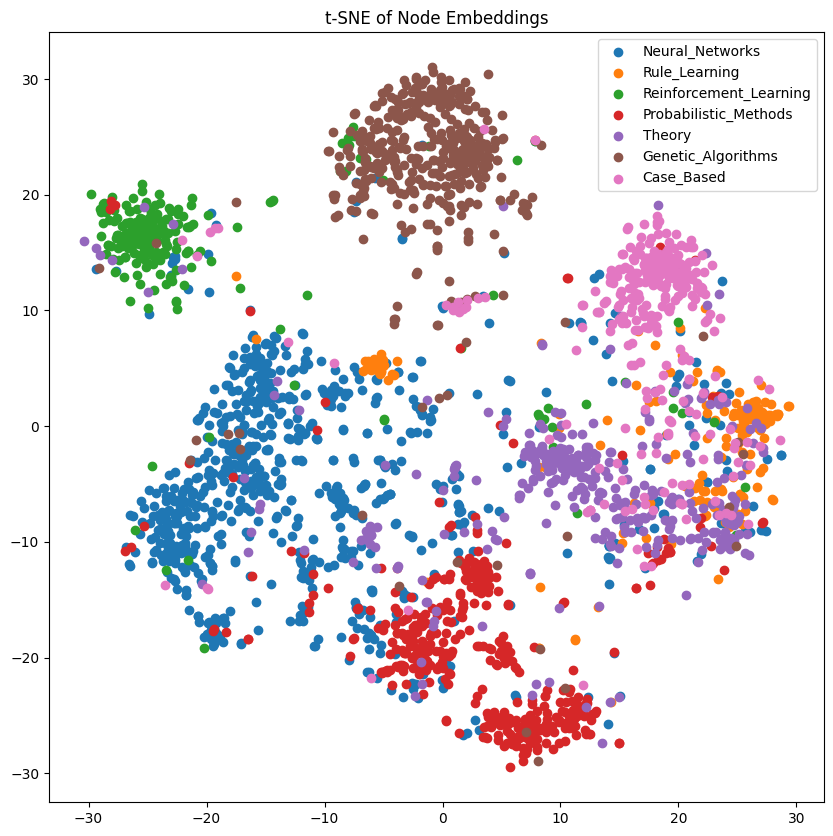

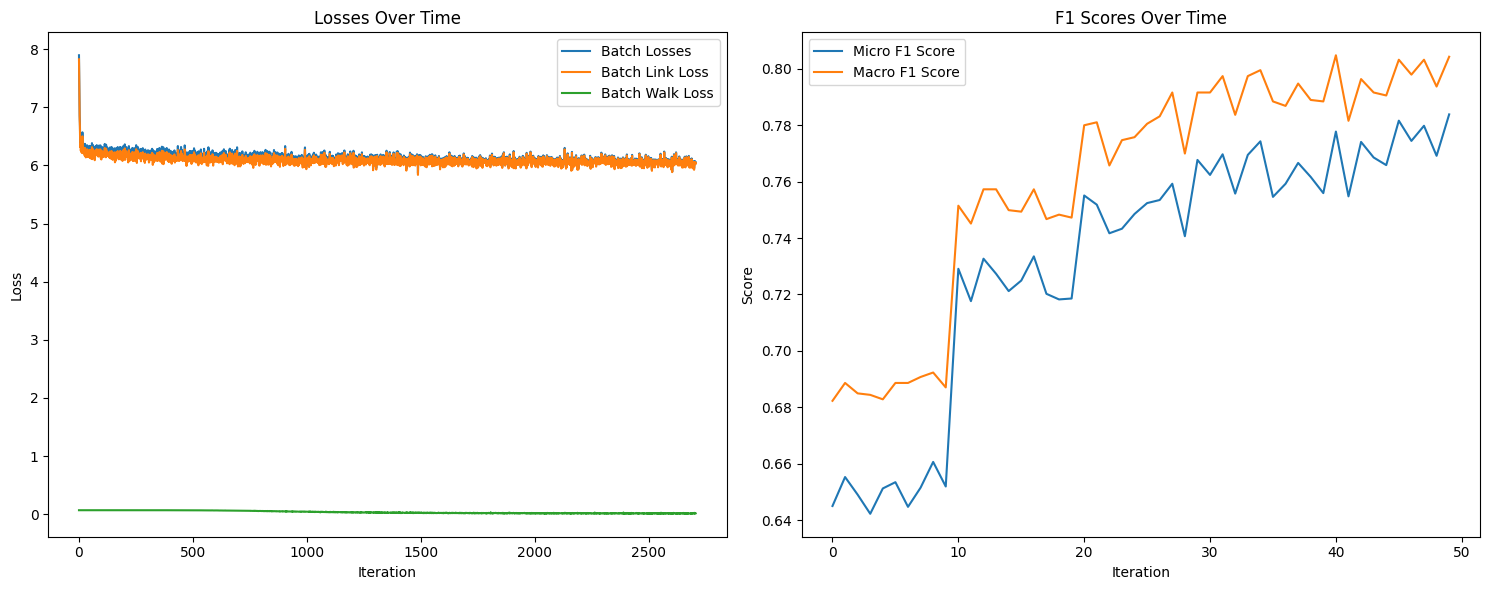

In [12]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import time
from tqdm import trange
device = get_device()

parser.radius = 1
print("Current p and q pair is: "+ str(parser.p)+"  "+str(parser.q))
print("Current radius is :" + str(generate_radius()))

if torch.cuda.is_available():
    torch.cuda.manual_seed(777)
else:
    torch.manual_seed(777)
np.random.seed(777)

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)


print("Generating RWs...")

alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)
node_anonymous_walks, node_walk_radius = generate_node_walks_and_radius(num_nodes, node_walks)
node_normalized_walk_distr, node_anonym_walktypes = process_anonym_distr(num_nodes, parser.anonym_walk_len, node_anonymous_walks)
types_and_nodes = generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius)  #(2708,500,2)
types_and_nodes = torch.tensor(types_and_nodes,device = device)
print("Generating Dataloader...")
dataset = Dataset(parser,
                  num_nodes,
                  g,
                  random_walks,
                  node_normalized_walk_distr)

def negative_sampling(keys, labels, neg_size):
    negs = np.zeros((neg_size))
    for j in range(neg_size):
        neg_ = random.choice(dataset.neg_sampling_seq)
        while (neg_ in labels or neg_ in keys):
            neg_ = random.choice(dataset.neg_sampling_seq)
        negs[j] = neg_
    return negs

def ns_collate(batch):
    keys, labels,walk_key, walk_label, walk_neg = zip(*batch)
    negs = negative_sampling(keys, labels, parser.neg_size)
    return torch.LongTensor(keys), torch.LongTensor(labels), torch.LongTensor(negs), torch.LongTensor(walk_key), torch.LongTensor(walk_label), torch.LongTensor(walk_neg)

# dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=6, collate_fn=ns_collate)
dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=3, collate_fn=ns_collate)


def train():
    save_path = parser.save_path + "/" + parser.dataset_name
    start_time = time.time()
    model = GraLSP(parser,
                   node_walks,
                   random_walks,
                   node_anonymous_walks,
                   node_walk_radius,
                   node_normalized_walk_distr,
                   node_anonym_walktypes,
                   types_and_nodes,
                   node_features,
                   node2label,
                   save_path)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parser.learning_rate)

    print("Start Training...")
    epochs = trange(parser.epochs, leave=True, desc="Epoch")
    for epoch in epochs:
        losses = 0
        batch_link_loss = []
        batch_walk_loss = []
        batch_losses = []
        micro, macro = [], []
        for i, data in enumerate(dataloader):
            # print("Inside 1")
            model.train()
            # print("Inside 1")
            optimizer.zero_grad()
            keys, labels, negs, walk_key, walk_label, walk_neg = data
            keys = keys.to(device)
            labels = labels.to(device)
            negs = negs.to(device)
            walk_key = walk_key.to(device)
            walk_label = walk_label.to(device)
            walk_neg = walk_neg.to(device)

            output_keys, output_labels, output_negs = model(keys, labels, negs)
            pos_aff = torch.sum(torch.multiply(output_keys, output_labels), axis = 1)
            neg_aff = torch.matmul(output_keys, output_negs.t())

            # pos_aff, neg_aff = model(keys, labels, negs)
            likelihood = torch.log(torch.sigmoid(pos_aff) + 1e-6) + torch.sum(torch.log(1-torch.sigmoid(neg_aff) + 1e-6), axis =1)
            link_loss = -torch.mean(likelihood)
            walk_loss = parser.walk_loss_lambda * model.criterion(walk_key,walk_label,walk_neg)
            # walk_loss = model.criterion(walk_key,walk_label,walk_neg)
            losses = link_loss + walk_loss

            losses.backward()
            optimizer.step()

            batch_link_loss.append(link_loss.item())
            batch_walk_loss.append(walk_loss.item())
            batch_losses.append(losses.item())


            epochs.set_description("Epoch (Loss=%g)" % round(np.mean(batch_losses), 5))
            if i and i % 500 == 0:

                mi, ma = model.evaluate_model()
                micro.extend(mi)
                macro.extend(ma)
                model.save_embeddings(i, save_model= False)

    return batch_losses, batch_link_loss, batch_walk_loss, micro, macro



if __name__ == "__main__":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # p, q = [4, 0.5,  2, .5], [2, 0.5,  0.5,  2]
    # for i in range(len(p)):
    for i in range(3):
      batch_losses, batch_link_loss, batch_walk_loss, micro, macro = train()
    draw_TSNE()
    draw_loss(batch_losses, batch_link_loss, batch_walk_loss, micro, macro)

### Fixed raidus 2

Current p and q pair is: 0.25  1
Current radius is :2
Reading dataset
cora
Generating nx graphs...
Generating RWs...


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Generating Dataloader...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Start Training...


Epoch (Loss=6.19134):   0%|          | 0/1 [01:36<?, ?it/s]

Node classification macro f1: 0.7482, std 0.0085
Node classification micro f1: 0.7742, std 0.0067
Embedding saved for step #500


Epoch (Loss=6.1494):   0%|          | 0/1 [03:08<?, ?it/s] 

Node classification macro f1: 0.7792, std 0.0064
Node classification micro f1: 0.7988, std 0.0062
Embedding saved for step #1000


Epoch (Loss=6.11946):   0%|          | 0/1 [04:42<?, ?it/s]

Node classification macro f1: 0.7995, std 0.0052
Node classification micro f1: 0.8155, std 0.0038
Embedding saved for step #1500


Epoch (Loss=6.0976):   0%|          | 0/1 [06:12<?, ?it/s] 

Node classification macro f1: 0.8067, std 0.0092
Node classification micro f1: 0.8236, std 0.0070
Embedding saved for step #2000


Epoch (Loss=6.08295):   0%|          | 0/1 [07:44<?, ?it/s]

Node classification macro f1: 0.8105, std 0.0079
Node classification micro f1: 0.8227, std 0.0054
Embedding saved for step #2500


Epoch (Loss=6.07778): 100%|██████████| 1/1 [08:20<00:00, 500.84s/it]


Start Training...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch (Loss=6.18433):   0%|          | 0/1 [01:31<?, ?it/s]

Node classification macro f1: 0.7512, std 0.0092
Node classification micro f1: 0.7790, std 0.0072
Embedding saved for step #500


Epoch (Loss=6.14232):   0%|          | 0/1 [03:09<?, ?it/s]

Node classification macro f1: 0.7880, std 0.0036
Node classification micro f1: 0.8065, std 0.0045
Embedding saved for step #1000


Epoch (Loss=6.11408):   0%|          | 0/1 [04:48<?, ?it/s]

Node classification macro f1: 0.8070, std 0.0063
Node classification micro f1: 0.8225, std 0.0055
Embedding saved for step #1500


Epoch (Loss=6.0943):   0%|          | 0/1 [06:21<?, ?it/s] 

Node classification macro f1: 0.8053, std 0.0068
Node classification micro f1: 0.8201, std 0.0069
Embedding saved for step #2000


Epoch (Loss=6.07894):   0%|          | 0/1 [07:57<?, ?it/s]

Node classification macro f1: 0.8056, std 0.0063
Node classification micro f1: 0.8197, std 0.0066
Embedding saved for step #2500


Epoch (Loss=6.07417): 100%|██████████| 1/1 [08:34<00:00, 514.98s/it]


Start Training...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch (Loss=6.19729):   0%|          | 0/1 [01:42<?, ?it/s]

Node classification macro f1: 0.7241, std 0.0074
Node classification micro f1: 0.7508, std 0.0068
Embedding saved for step #500


Epoch (Loss=6.15258):   0%|          | 0/1 [03:26<?, ?it/s]

Node classification macro f1: 0.7869, std 0.0119
Node classification micro f1: 0.8080, std 0.0079
Embedding saved for step #1000


Epoch (Loss=6.12047):   0%|          | 0/1 [05:02<?, ?it/s]

Node classification macro f1: 0.8100, std 0.0079
Node classification micro f1: 0.8263, std 0.0064
Embedding saved for step #1500


Epoch (Loss=6.09782):   0%|          | 0/1 [06:40<?, ?it/s]

Node classification macro f1: 0.8110, std 0.0099
Node classification micro f1: 0.8260, std 0.0076
Embedding saved for step #2000


Epoch (Loss=6.08184):   0%|          | 0/1 [08:22<?, ?it/s]

Node classification macro f1: 0.8163, std 0.0051
Node classification micro f1: 0.8298, std 0.0051
Embedding saved for step #2500


Epoch (Loss=6.07634): 100%|██████████| 1/1 [09:02<00:00, 542.47s/it]


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.001s...
[t-SNE] Computed neighbors for 2708 samples in 0.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.353334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.382416
[t-SNE] KL divergence after 600 iterations: 0.793125
The average silhouette score for 7 clusters is: 0.501986026763916


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


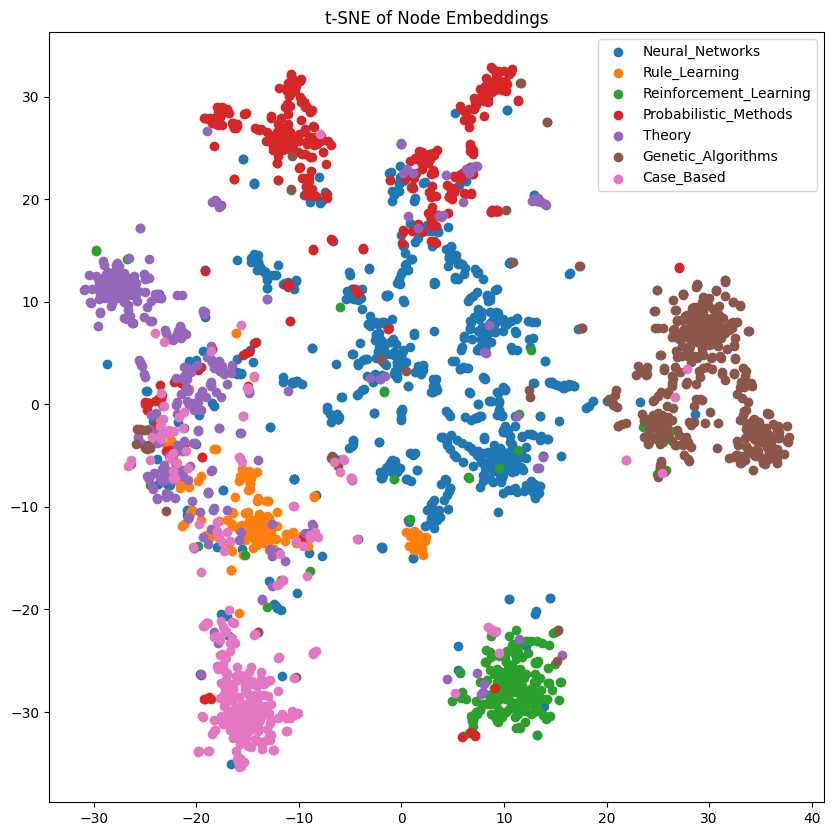

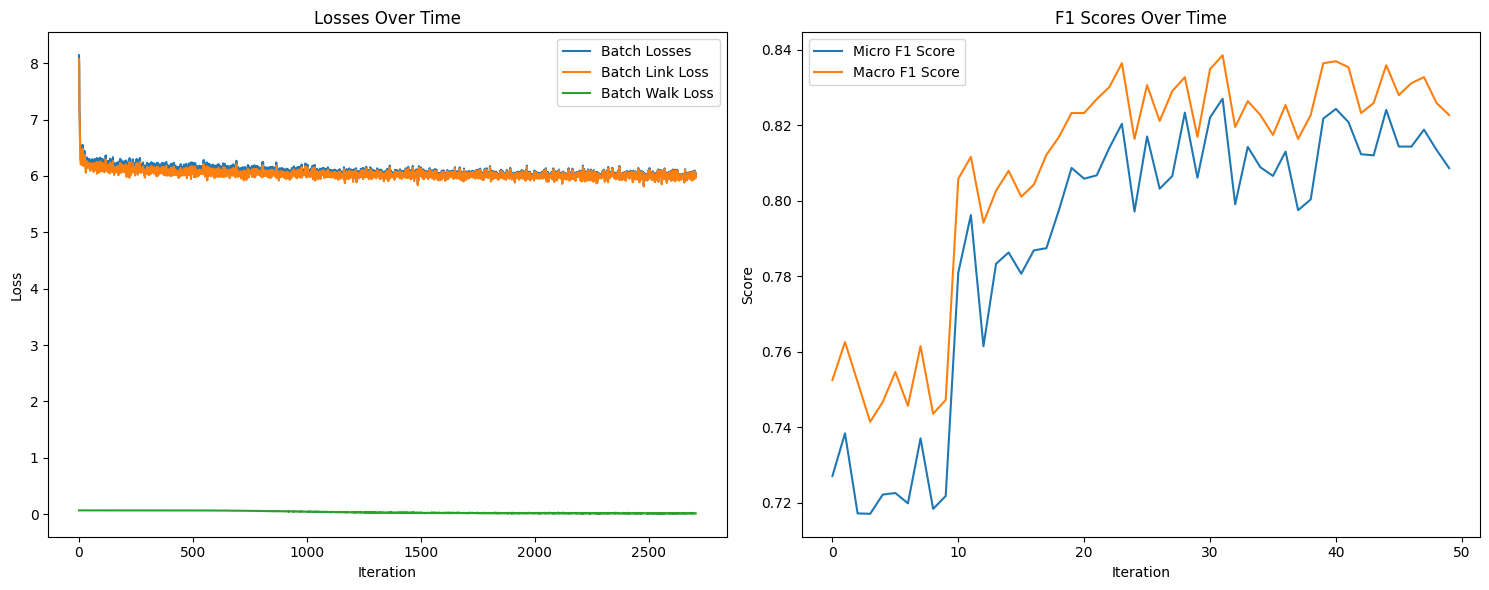

In [13]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import time
from tqdm import trange
device = get_device()

parser.radius = 2
print("Current p and q pair is: "+ str(parser.p)+"  "+str(parser.q))
print("Current radius is :" + str(generate_radius()))
batch_link_loss = []
batch_walk_loss = []
batch_losses = []

if torch.cuda.is_available():
    torch.cuda.manual_seed(777)
else:
    torch.manual_seed(777)
np.random.seed(777)

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)


print("Generating RWs...")

alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)
node_anonymous_walks, node_walk_radius = generate_node_walks_and_radius(num_nodes, node_walks)
node_normalized_walk_distr, node_anonym_walktypes = process_anonym_distr(num_nodes, parser.anonym_walk_len, node_anonymous_walks)
types_and_nodes = generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius)  #(2708,500,2)
types_and_nodes = torch.tensor(types_and_nodes,device = device)
print("Generating Dataloader...")
dataset = Dataset(parser,
                  num_nodes,
                  g,
                  random_walks,
                  node_normalized_walk_distr)

def negative_sampling(keys, labels, neg_size):
    negs = np.zeros((neg_size))
    for j in range(neg_size):
        neg_ = random.choice(dataset.neg_sampling_seq)
        while (neg_ in labels or neg_ in keys):
            neg_ = random.choice(dataset.neg_sampling_seq)
        negs[j] = neg_
    return negs

def ns_collate(batch):
    keys, labels,walk_key, walk_label, walk_neg = zip(*batch)
    negs = negative_sampling(keys, labels, parser.neg_size)
    return torch.LongTensor(keys), torch.LongTensor(labels), torch.LongTensor(negs), torch.LongTensor(walk_key), torch.LongTensor(walk_label), torch.LongTensor(walk_neg)

# dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=6, collate_fn=ns_collate)
dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=3, collate_fn=ns_collate)


def train():
    save_path = parser.save_path + "/" + parser.dataset_name
    start_time = time.time()
    model = GraLSP(parser,
                   node_walks,
                   random_walks,
                   node_anonymous_walks,
                   node_walk_radius,
                   node_normalized_walk_distr,
                   node_anonym_walktypes,
                   types_and_nodes,
                   node_features,
                   node2label,
                   save_path)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parser.learning_rate)

    print("Start Training...")
    epochs = trange(parser.epochs, leave=True, desc="Epoch")
    for epoch in epochs:
        losses = 0
        batch_link_loss = []
        batch_walk_loss = []
        batch_losses = []
        micro, macro = [], []
        for i, data in enumerate(dataloader):
            # print("Inside 1")
            model.train()
            # print("Inside 1")
            optimizer.zero_grad()
            keys, labels, negs, walk_key, walk_label, walk_neg = data
            keys = keys.to(device)
            labels = labels.to(device)
            negs = negs.to(device)
            walk_key = walk_key.to(device)
            walk_label = walk_label.to(device)
            walk_neg = walk_neg.to(device)

            output_keys, output_labels, output_negs = model(keys, labels, negs)
            pos_aff = torch.sum(torch.multiply(output_keys, output_labels), axis = 1)
            neg_aff = torch.matmul(output_keys, output_negs.t())

            # pos_aff, neg_aff = model(keys, labels, negs)
            likelihood = torch.log(torch.sigmoid(pos_aff) + 1e-6) + torch.sum(torch.log(1-torch.sigmoid(neg_aff) + 1e-6), axis =1)
            link_loss = -torch.mean(likelihood)
            walk_loss = parser.walk_loss_lambda * model.criterion(walk_key,walk_label,walk_neg)
            # walk_loss = model.criterion(walk_key,walk_label,walk_neg)
            losses = link_loss + walk_loss

            losses.backward()
            optimizer.step()

            batch_link_loss.append(link_loss.item())
            batch_walk_loss.append(walk_loss.item())
            batch_losses.append(losses.item())



            epochs.set_description("Epoch (Loss=%g)" % round(np.mean(batch_losses), 5))
            if i and i % 500 == 0:

                mi, ma = model.evaluate_model()
                micro.extend(mi)
                macro.extend(ma)
                model.save_embeddings(i, save_model= False)

    return batch_losses, batch_link_loss, batch_walk_loss, micro, macro



if __name__ == "__main__":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # p, q = [4, 0.5,  2, .5], [2, 0.5,  0.5,  2]
    # for i in range(len(p)):

    for i in range(3):
      batch_losses, batch_link_loss, batch_walk_loss, micro, macro = train()
    draw_TSNE()
    draw_loss(batch_losses, batch_link_loss, batch_walk_loss, micro, macro)

### Global Structure, Low p High q

Current p and q pair is: 1  5
Current radius is :5
Reading dataset
cora
Generating nx graphs...
Generating RWs...


100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Generating Dataloader...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Start Training...


Epoch (Loss=6.18212):   0%|          | 0/1 [01:28<?, ?it/s]

Node classification macro f1: 0.7435, std 0.0088
Node classification micro f1: 0.7695, std 0.0073
Embedding saved for step #500


Epoch (Loss=6.14225):   0%|          | 0/1 [02:54<?, ?it/s]

Node classification macro f1: 0.7865, std 0.0064
Node classification micro f1: 0.8042, std 0.0053
Embedding saved for step #1000


Epoch (Loss=6.12162):   0%|          | 0/1 [04:21<?, ?it/s]

Node classification macro f1: 0.8013, std 0.0067
Node classification micro f1: 0.8160, std 0.0053
Embedding saved for step #1500


Epoch (Loss=6.10742):   0%|          | 0/1 [05:46<?, ?it/s]

Node classification macro f1: 0.8039, std 0.0099
Node classification micro f1: 0.8168, std 0.0088
Embedding saved for step #2000


Epoch (Loss=6.09572):   0%|          | 0/1 [07:08<?, ?it/s]

Node classification macro f1: 0.8058, std 0.0087
Node classification micro f1: 0.8231, std 0.0066
Embedding saved for step #2500


Epoch (Loss=6.0917): 100%|██████████| 1/1 [07:40<00:00, 460.59s/it]


Start Training...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch (Loss=6.18079):   0%|          | 0/1 [01:25<?, ?it/s]

Node classification macro f1: 0.7664, std 0.0100
Node classification micro f1: 0.7900, std 0.0080
Embedding saved for step #500


Epoch (Loss=6.14192):   0%|          | 0/1 [02:48<?, ?it/s]

Node classification macro f1: 0.8095, std 0.0099
Node classification micro f1: 0.8245, std 0.0086
Embedding saved for step #1000


Epoch (Loss=6.12128):   0%|          | 0/1 [04:11<?, ?it/s]

Node classification macro f1: 0.8125, std 0.0057
Node classification micro f1: 0.8280, std 0.0051
Embedding saved for step #1500


Epoch (Loss=6.10682):   0%|          | 0/1 [05:36<?, ?it/s]

Node classification macro f1: 0.8233, std 0.0064
Node classification micro f1: 0.8333, std 0.0051
Embedding saved for step #2000


Epoch (Loss=6.0943):   0%|          | 0/1 [06:59<?, ?it/s] 

Node classification macro f1: 0.8229, std 0.0078
Node classification micro f1: 0.8350, std 0.0070
Embedding saved for step #2500


Epoch (Loss=6.08956): 100%|██████████| 1/1 [07:33<00:00, 453.31s/it]


Start Training...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch (Loss=6.18068):   0%|          | 0/1 [01:25<?, ?it/s]

Node classification macro f1: 0.7653, std 0.0079
Node classification micro f1: 0.7897, std 0.0045
Embedding saved for step #500


Epoch (Loss=6.14192):   0%|          | 0/1 [02:47<?, ?it/s]

Node classification macro f1: 0.7906, std 0.0050
Node classification micro f1: 0.8099, std 0.0050
Embedding saved for step #1000


Epoch (Loss=6.12097):   0%|          | 0/1 [04:11<?, ?it/s]

Node classification macro f1: 0.7934, std 0.0056
Node classification micro f1: 0.8125, std 0.0045
Embedding saved for step #1500


Epoch (Loss=6.10532):   0%|          | 0/1 [05:33<?, ?it/s]

Node classification macro f1: 0.8008, std 0.0048
Node classification micro f1: 0.8150, std 0.0045
Embedding saved for step #2000


Epoch (Loss=6.09458):   0%|          | 0/1 [07:01<?, ?it/s]

Node classification macro f1: 0.8011, std 0.0096
Node classification micro f1: 0.8160, std 0.0075
Embedding saved for step #2500


Epoch (Loss=6.09101): 100%|██████████| 1/1 [07:35<00:00, 455.01s/it]


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.002s...
[t-SNE] Computed neighbors for 2708 samples in 0.261s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.344301
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.405495
[t-SNE] KL divergence after 600 iterations: 0.733895


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score for 7 clusters is: 0.4662562906742096


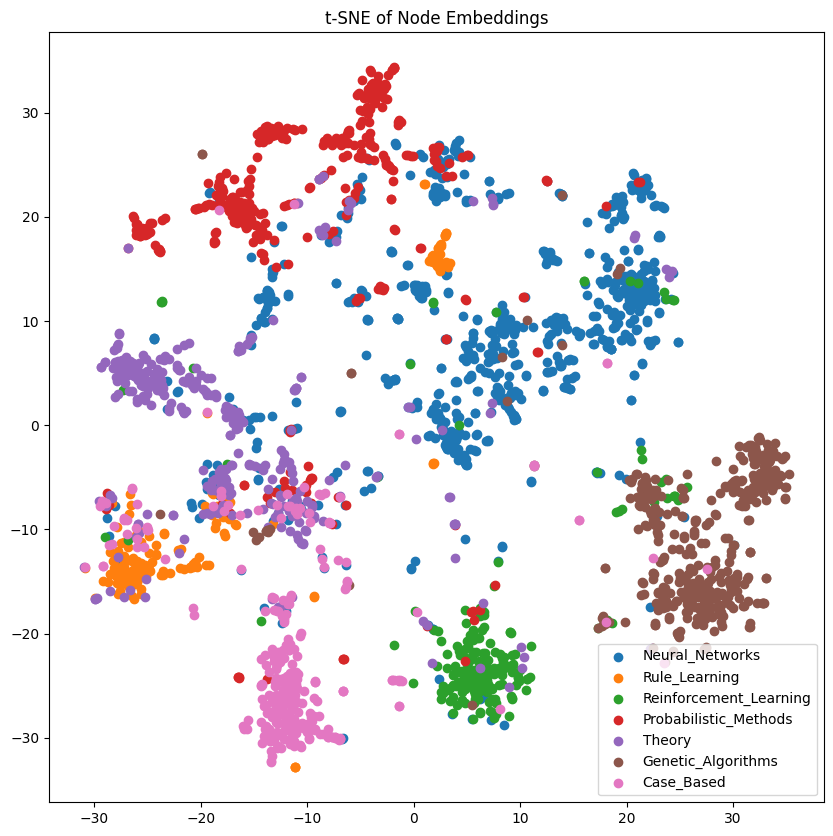

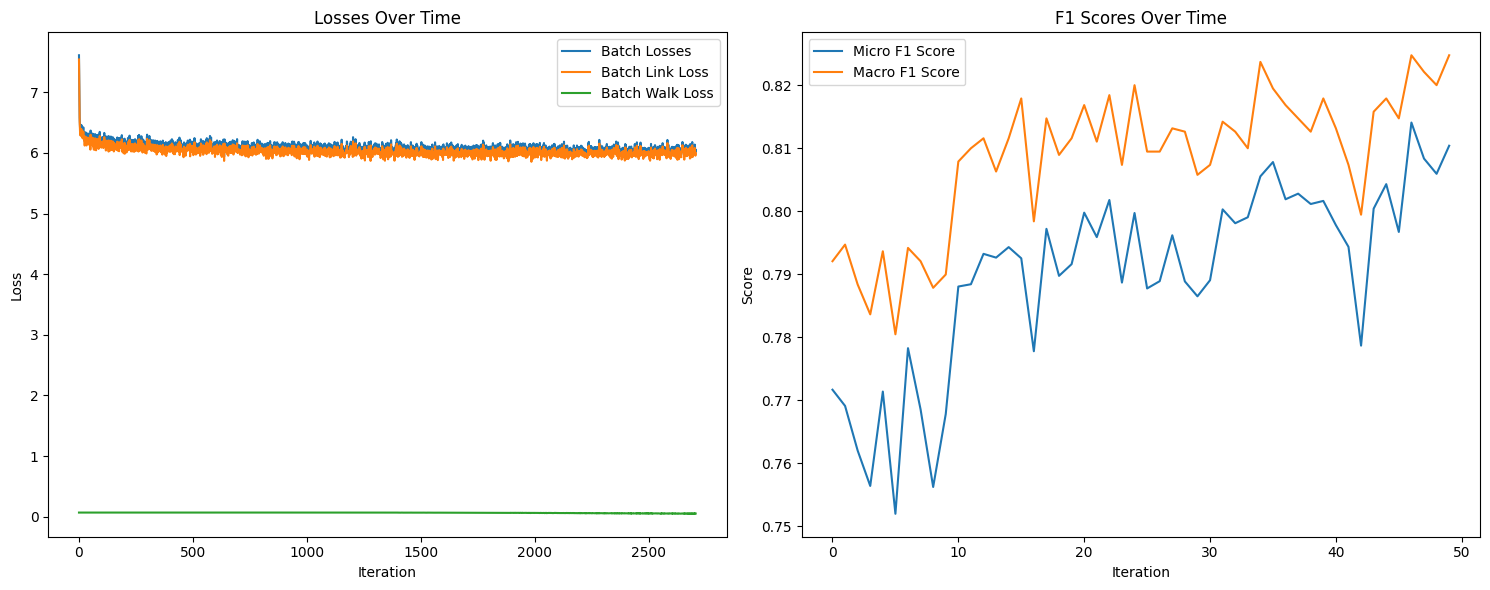

In [15]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import time
from tqdm import trange
device = get_device()

if torch.cuda.is_available():
    torch.cuda.manual_seed(777)
else:
    torch.manual_seed(777)
np.random.seed(777)

batch_link_loss = []
batch_walk_loss = []
batch_losses = []
micro = []
macro = []

parser.p = 1
parser.q = 5
parser.radius = 100
print("Current p and q pair is: "+ str(parser.p)+"  "+str(parser.q))
print("Current radius is :" + str(generate_radius()))

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)


print("Generating RWs...")

alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)


node_anonymous_walks, node_walk_radius = generate_node_walks_and_radius(num_nodes, node_walks)


node_normalized_walk_distr, node_anonym_walktypes = process_anonym_distr(num_nodes, parser.anonym_walk_len, node_anonymous_walks)

types_and_nodes = generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius)  #(2708,500,2)

types_and_nodes = torch.tensor(types_and_nodes,device = device)

print("Generating Dataloader...")
dataset = Dataset(parser,
                  num_nodes,
                  g,
                  random_walks,
                  node_normalized_walk_distr)

def negative_sampling(keys, labels, neg_size):
    negs = np.zeros((neg_size))
    for j in range(neg_size):
        neg_ = random.choice(dataset.neg_sampling_seq)
        while (neg_ in labels or neg_ in keys):
            neg_ = random.choice(dataset.neg_sampling_seq)
        negs[j] = neg_
    return negs

def ns_collate(batch):
    keys, labels,walk_key, walk_label, walk_neg = zip(*batch)
    negs = negative_sampling(keys, labels, parser.neg_size)
    return torch.LongTensor(keys), torch.LongTensor(labels), torch.LongTensor(negs), torch.LongTensor(walk_key), torch.LongTensor(walk_label), torch.LongTensor(walk_neg)

# dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=6, collate_fn=ns_collate)
dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=3, collate_fn=ns_collate)


def train():
    save_path = parser.save_path + "/" + parser.dataset_name
    start_time = time.time()
    model = GraLSP(parser,
                   node_walks,
                   random_walks,
                   node_anonymous_walks,
                   node_walk_radius,
                   node_normalized_walk_distr,
                   node_anonym_walktypes,
                   types_and_nodes,
                   node_features,
                   node2label,
                   save_path)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parser.learning_rate)

    print("Start Training...")
    epochs = trange(parser.epochs, leave=True, desc="Epoch")
    for epoch in epochs:
        losses = 0
        batch_link_loss = []
        batch_walk_loss = []
        batch_losses = []
        micro, macro = [], []
        for i, data in enumerate(dataloader):
            # print("Inside 1")
            model.train()
            # print("Inside 1")
            optimizer.zero_grad()
            keys, labels, negs, walk_key, walk_label, walk_neg = data
            keys = keys.to(device)
            labels = labels.to(device)
            negs = negs.to(device)
            walk_key = walk_key.to(device)
            walk_label = walk_label.to(device)
            walk_neg = walk_neg.to(device)

            output_keys, output_labels, output_negs = model(keys, labels, negs)
            pos_aff = torch.sum(torch.multiply(output_keys, output_labels), axis = 1)
            neg_aff = torch.matmul(output_keys, output_negs.t())

            # pos_aff, neg_aff = model(keys, labels, negs)
            likelihood = torch.log(torch.sigmoid(pos_aff) + 1e-6) + torch.sum(torch.log(1-torch.sigmoid(neg_aff) + 1e-6), axis =1)
            link_loss = -torch.mean(likelihood)
            walk_loss = parser.walk_loss_lambda * model.criterion(walk_key,walk_label,walk_neg)
            # walk_loss = model.criterion(walk_key,walk_label,walk_neg)
            losses = link_loss + walk_loss

            losses.backward()
            optimizer.step()

            batch_link_loss.append(link_loss.item())
            batch_walk_loss.append(walk_loss.item())
            batch_losses.append(losses.item())



            epochs.set_description("Epoch (Loss=%g)" % round(np.mean(batch_losses), 5))
            if i and i % 500 == 0:

                mi, ma = model.evaluate_model()
                micro.extend(mi)
                macro.extend(ma)
                model.save_embeddings(i, save_model= False)

    return batch_losses, batch_link_loss, batch_walk_loss, micro, macro



if __name__ == "__main__":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # p, q = [4, 0.5,  2, .5], [2, 0.5,  0.5,  2]
    # for i in range(len(p)):

    for i in range(3):
      batch_losses, batch_link_loss, batch_walk_loss, micro, macro = train()
    draw_TSNE()
    draw_loss(batch_losses, batch_link_loss, batch_walk_loss, micro, macro)

### Local Structure, High p Low q

Current p and q pair is: 5  1
Current radius is :1
Reading dataset
cora
Generating nx graphs...
Generating RWs...


100%|██████████| 100/100 [00:15<00:00,  6.51it/s]


Generating Dataloader...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Start Training...


Epoch (Loss=6.27662):   0%|          | 0/1 [01:51<?, ?it/s]

Node classification macro f1: 0.6760, std 0.0069
Node classification micro f1: 0.7224, std 0.0049
Embedding saved for step #500


Epoch (Loss=6.23878):   0%|          | 0/1 [03:38<?, ?it/s]

Node classification macro f1: 0.7239, std 0.0082
Node classification micro f1: 0.7584, std 0.0053
Embedding saved for step #1000


Epoch (Loss=6.21269):   0%|          | 0/1 [05:27<?, ?it/s]

Node classification macro f1: 0.7487, std 0.0063
Node classification micro f1: 0.7775, std 0.0069
Embedding saved for step #1500


Epoch (Loss=6.19287):   0%|          | 0/1 [07:12<?, ?it/s]

Node classification macro f1: 0.7602, std 0.0096
Node classification micro f1: 0.7870, std 0.0078
Embedding saved for step #2000


Epoch (Loss=6.17715):   0%|          | 0/1 [08:57<?, ?it/s]

Node classification macro f1: 0.7781, std 0.0084
Node classification micro f1: 0.7986, std 0.0068
Embedding saved for step #2500


Epoch (Loss=6.17208): 100%|██████████| 1/1 [09:42<00:00, 582.16s/it]


[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2708 samples in 0.001s...
[t-SNE] Computed neighbors for 2708 samples in 0.197s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.324660
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.682671
[t-SNE] KL divergence after 600 iterations: 0.997985


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The average silhouette score for 7 clusters is: 0.4951719045639038


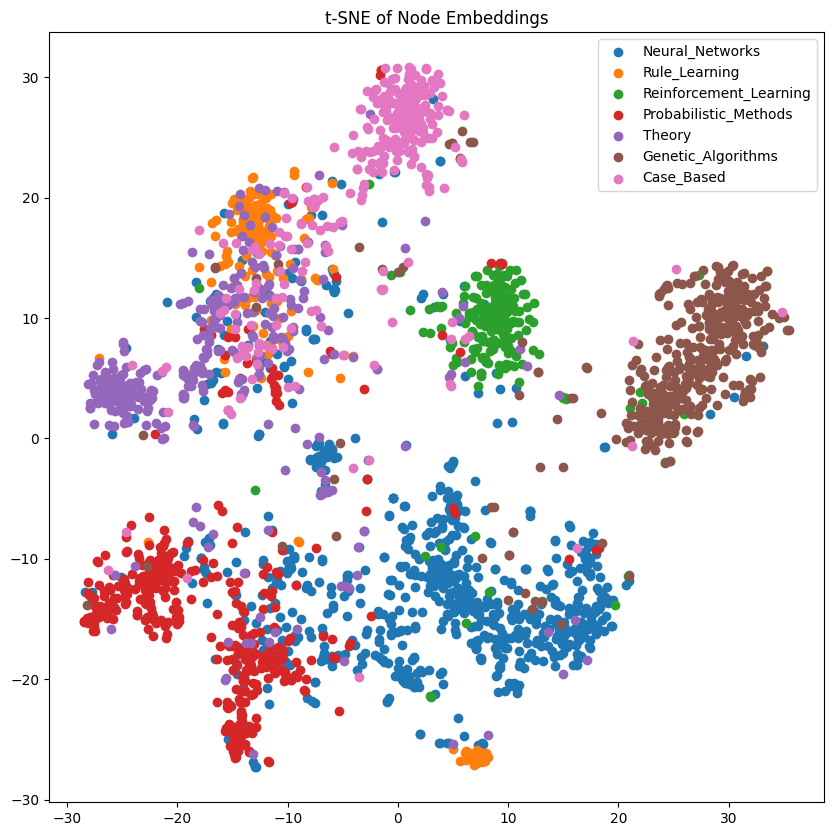

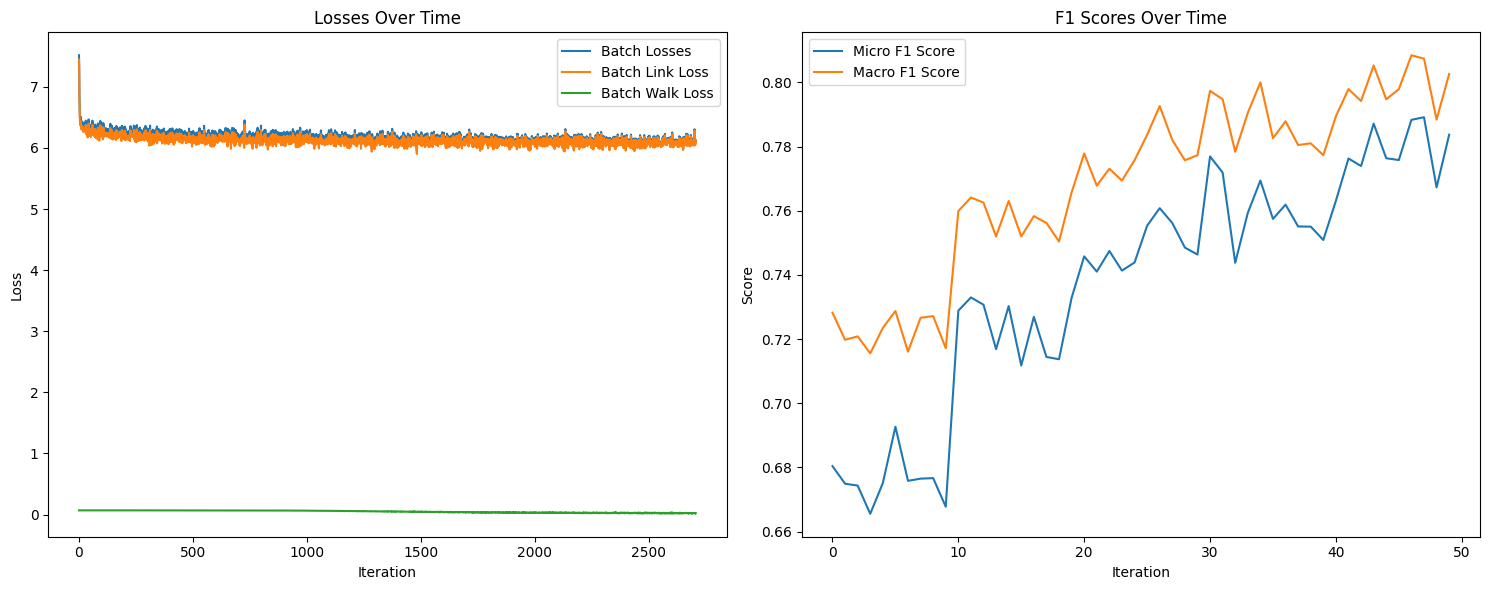

In [43]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import time
from tqdm import trange
device = get_device()

if torch.cuda.is_available():
    torch.cuda.manual_seed(777)
else:
    torch.manual_seed(777)
np.random.seed(777)

batch_link_loss = []
batch_walk_loss = []
batch_losses = []
micro = []
macro = []

parser.p = 5
parser.q = 1
parser.radius = 1
print("Current p and q pair is: "+ str(parser.p)+"  "+str(parser.q))
print("Current radius is :" + str(generate_radius()))

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)


print("Generating RWs...")

alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)


node_anonymous_walks, node_walk_radius = generate_node_walks_and_radius(num_nodes, node_walks)


node_normalized_walk_distr, node_anonym_walktypes = process_anonym_distr(num_nodes, parser.anonym_walk_len, node_anonymous_walks)

types_and_nodes = generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius)  #(2708,500,2)

types_and_nodes = torch.tensor(types_and_nodes,device = device)

print("Generating Dataloader...")
dataset = Dataset(parser,
                  num_nodes,
                  g,
                  random_walks,
                  node_normalized_walk_distr)

def negative_sampling(keys, labels, neg_size):
    negs = np.zeros((neg_size))
    for j in range(neg_size):
        neg_ = random.choice(dataset.neg_sampling_seq)
        while (neg_ in labels or neg_ in keys):
            neg_ = random.choice(dataset.neg_sampling_seq)
        negs[j] = neg_
    return negs

def ns_collate(batch):
    keys, labels,walk_key, walk_label, walk_neg = zip(*batch)
    negs = negative_sampling(keys, labels, parser.neg_size)
    return torch.LongTensor(keys), torch.LongTensor(labels), torch.LongTensor(negs), torch.LongTensor(walk_key), torch.LongTensor(walk_label), torch.LongTensor(walk_neg)

# dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=6, collate_fn=ns_collate)
dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=3, collate_fn=ns_collate)


def train():
    save_path = parser.save_path + "/" + parser.dataset_name
    start_time = time.time()
    model = GraLSP(parser,
                   node_walks,
                   random_walks,
                   node_anonymous_walks,
                   node_walk_radius,
                   node_normalized_walk_distr,
                   node_anonym_walktypes,
                   types_and_nodes,
                   node_features,
                   node2label,
                   save_path)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parser.learning_rate)

    print("Start Training...")
    epochs = trange(parser.epochs, leave=True, desc="Epoch")
    for epoch in epochs:
        losses = 0
        batch_link_loss = []
        batch_walk_loss = []
        batch_losses = []
        micro, macro = [], []
        for i, data in enumerate(dataloader):
            # print("Inside 1")
            model.train()
            # print("Inside 1")
            optimizer.zero_grad()
            keys, labels, negs, walk_key, walk_label, walk_neg = data
            keys = keys.to(device)
            labels = labels.to(device)
            negs = negs.to(device)
            walk_key = walk_key.to(device)
            walk_label = walk_label.to(device)
            walk_neg = walk_neg.to(device)

            output_keys, output_labels, output_negs = model(keys, labels, negs)
            pos_aff = torch.sum(torch.multiply(output_keys, output_labels), axis = 1)
            neg_aff = torch.matmul(output_keys, output_negs.t())

            # pos_aff, neg_aff = model(keys, labels, negs)
            likelihood = torch.log(torch.sigmoid(pos_aff) + 1e-6) + torch.sum(torch.log(1-torch.sigmoid(neg_aff) + 1e-6), axis =1)
            link_loss = -torch.mean(likelihood)
            walk_loss = parser.walk_loss_lambda * model.criterion(walk_key,walk_label,walk_neg)
            # walk_loss = model.criterion(walk_key,walk_label,walk_neg)
            losses = link_loss + walk_loss

            losses.backward()
            optimizer.step()

            batch_link_loss.append(link_loss.item())
            batch_walk_loss.append(walk_loss.item())
            batch_losses.append(losses.item())



            epochs.set_description("Epoch (Loss=%g)" % round(np.mean(batch_losses), 5))
            if i and i % 500 == 0:

                mi, ma = model.evaluate_model()
                micro.extend(mi)
                macro.extend(ma)
                model.save_embeddings(i, save_model= False)

    return batch_losses, batch_link_loss, batch_walk_loss, micro, macro


if __name__ == "__main__":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # p, q = [4, 0.5,  2, .5], [2, 0.5,  0.5,  2]
    # for i in range(len(p)):



    for i in range(3):
      batch_losses, batch_link_loss, batch_walk_loss, micro, macro = train()
    draw_TSNE()
    draw_loss(batch_losses, batch_link_loss, batch_walk_loss, micro, macro)

## Draft

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import time
from tqdm import trange
device = get_device()

if torch.cuda.is_available():
    torch.cuda.manual_seed(777)
else:
    torch.manual_seed(777)
np.random.seed(777)

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)


print("Generating RWs...")

alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)

node_anonymous_walks, node_walk_radius = generate_node_walks_and_radius(num_nodes, node_walks)

node_normalized_walk_distr, node_anonym_walktypes = process_anonym_distr(num_nodes, parser.anonym_walk_len, node_anonymous_walks)

types_and_nodes = generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius)  #(2708,500,2)

types_and_nodes = torch.tensor(types_and_nodes,device = device)

print("Generating Dataloader...")
dataset = Dataset(parser,
                  num_nodes,
                  g,
                  random_walks,
                  node_normalized_walk_distr)

def negative_sampling(keys, labels, neg_size):
    negs = np.zeros((neg_size))
    for j in range(neg_size):
        neg_ = random.choice(dataset.neg_sampling_seq)
        while (neg_ in labels or neg_ in keys):
            neg_ = random.choice(dataset.neg_sampling_seq)
        negs[j] = neg_
    return negs

def ns_collate(batch):
    keys, labels,walk_key, walk_label, walk_neg = zip(*batch)
    negs = negative_sampling(keys, labels, parser.neg_size)
    return torch.LongTensor(keys), torch.LongTensor(labels), torch.LongTensor(negs), torch.LongTensor(walk_key), torch.LongTensor(walk_label), torch.LongTensor(walk_neg)

# dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=6, collate_fn=ns_collate)
dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=2, collate_fn=ns_collate)


def train():
    save_path = parser.save_path + "/" + parser.dataset_name
    start_time = time.time()
    model = GraLSP(parser,
                   node_walks,
                   random_walks,
                   node_anonymous_walks,
                   node_walk_radius,
                   node_normalized_walk_distr,
                   node_anonym_walktypes,
                   types_and_nodes,
                   node_features,
                   node2label,
                   save_path)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parser.learning_rate)

    print("Start Training...")
    epochs = trange(parser.epochs, leave=True, desc="Epoch")
    for epoch in epochs:
        losses = 0
        batch_link_loss = []
        batch_walk_loss = []
        batch_losses = []
        for i, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            keys, labels, negs, walk_key, walk_label, walk_neg = data
            keys = keys.to(device)
            labels = labels.to(device)
            negs = negs.to(device)
            walk_key = walk_key.to(device)
            walk_label = walk_label.to(device)
            walk_neg = walk_neg.to(device)

            output_keys, output_labels, output_negs = model(keys, labels, negs)
            pos_aff = torch.sum(torch.multiply(output_keys, output_labels), axis = 1)
            neg_aff = torch.matmul(output_keys, output_negs.t())

            # pos_aff, neg_aff = model(keys, labels, negs)
            likelihood = torch.log(torch.sigmoid(pos_aff) + 1e-6) + torch.sum(torch.log(1-torch.sigmoid(neg_aff) + 1e-6), axis =1)
            link_loss = -torch.mean(likelihood)
            walk_loss = parser.walk_loss_lambda * model.criterion(walk_key,walk_label,walk_neg)
            # walk_loss = model.criterion(walk_key,walk_label,walk_neg)
            losses = link_loss + walk_loss

            losses.backward()
            optimizer.step()

            batch_link_loss.append(link_loss.item())
            batch_walk_loss.append(walk_loss.item())
            batch_losses.append(losses.item())



            epochs.set_description("Epoch (Loss=%g)" % round(np.mean(batch_losses), 5))
            if i and i % 500 == 0:

                model.evaluate_model()
                model.save_embeddings(i, save_model= False)




if __name__ == "__main__":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # p, q = [4, 0.5,  2, .5], [2, 0.5,  0.5,  2]
    # for i in range(len(p)):

    parser.p = 1
    parser.q = 16
    print("Current p and q pair is: "+ str(parser.p)+"  "+str(parser.q))

    train()

Reading dataset
cora
Generating nx graphs...
Generating RWs...


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


Generating Dataloader...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Current p and q pair is: 1  16
Start Training...


Epoch (Loss=6.2801):   0%|          | 0/1 [02:06<?, ?it/s] 

Node classification macro f1: 0.6513, std 0.0144
Node classification micro f1: 0.7032, std 0.0051
Embedding saved for step #500


Epoch (Loss=6.23928):   0%|          | 0/1 [04:06<?, ?it/s]

Node classification macro f1: 0.7180, std 0.0093
Node classification micro f1: 0.7564, std 0.0064
Embedding saved for step #1000


Epoch (Loss=6.21106):   0%|          | 0/1 [06:04<?, ?it/s]

Node classification macro f1: 0.7495, std 0.0070
Node classification micro f1: 0.7796, std 0.0048
Embedding saved for step #1500


Epoch (Loss=6.19057):   0%|          | 0/1 [08:01<?, ?it/s]

Node classification macro f1: 0.7575, std 0.0114
Node classification micro f1: 0.7861, std 0.0075
Embedding saved for step #2000


Epoch (Loss=6.17474):   0%|          | 0/1 [10:02<?, ?it/s]

Node classification macro f1: 0.7665, std 0.0078
Node classification micro f1: 0.7935, std 0.0058
Embedding saved for step #2500


Epoch (Loss=6.16835): 100%|██████████| 1/1 [10:49<00:00, 649.86s/it]


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import random
import time
from tqdm import trange
device = get_device()

if torch.cuda.is_available():
    torch.cuda.manual_seed(777)
else:
    torch.manual_seed(777)
np.random.seed(777)

print("Reading dataset")
edge_list, num_nodes = get_edge_list(parser)
print("Generating nx graphs...")
g = edge_list2nx(edge_list, num_nodes)
node_features = torch.tensor(np.load("data/" + parser.dataset_name + "/features.npy"), device = device)
parser.feature_dims = len(node_features[0])
node2label = get_node2label(num_nodes)


print("Generating RWs...")

alias_nodes, alias_edges = preprocess_transition_prob(g,num_nodes)
node_walks, random_walks = generate_node2vec_walks(g, num_nodes, alias_nodes, alias_edges)

node_anonymous_walks, node_walk_radius = generate_node_walks_and_radius(num_nodes, node_walks)

node_normalized_walk_distr, node_anonym_walktypes = process_anonym_distr(num_nodes, parser.anonym_walk_len, node_anonymous_walks)

types_and_nodes = generate_types_and_nodes(num_nodes, node_anonym_walktypes, node_walks, node_walk_radius)  #(2708,500,2)

types_and_nodes = torch.tensor(types_and_nodes,device = device)

print("Generating Dataloader...")
dataset = Dataset(parser,
                  num_nodes,
                  g,
                  random_walks,
                  node_normalized_walk_distr)

def negative_sampling(keys, labels, neg_size):
    negs = np.zeros((neg_size))
    for j in range(neg_size):
        neg_ = random.choice(dataset.neg_sampling_seq)
        while (neg_ in labels or neg_ in keys):
            neg_ = random.choice(dataset.neg_sampling_seq)
        negs[j] = neg_
    return negs

def ns_collate(batch):
    keys, labels,walk_key, walk_label, walk_neg = zip(*batch)
    negs = negative_sampling(keys, labels, parser.neg_size)
    return torch.LongTensor(keys), torch.LongTensor(labels), torch.LongTensor(negs), torch.LongTensor(walk_key), torch.LongTensor(walk_label), torch.LongTensor(walk_neg)

# dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=6, collate_fn=ns_collate)
dataloader = DataLoader(dataset, shuffle=True, batch_size=parser.batch_size, num_workers=6, collate_fn=ns_collate)


def train():
    save_path = parser.save_path + "/" + parser.dataset_name
    start_time = time.time()
    model = GraLSP(parser,
                   node_walks,
                   random_walks,
                   node_anonymous_walks,
                   node_walk_radius,
                   node_normalized_walk_distr,
                   node_anonym_walktypes,
                   types_and_nodes,
                   node_features,
                   node2label,
                   save_path)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parser.learning_rate)

    print("Start Training...")
    epochs = trange(parser.epochs, leave=True, desc="Epoch")
    for epoch in epochs:
        losses = 0
        batch_link_loss = []
        batch_walk_loss = []
        batch_losses = []
        for i, data in enumerate(dataloader):
            model.train()
            optimizer.zero_grad()
            keys, labels, negs, walk_key, walk_label, walk_neg = data
            keys = keys.to(device)
            labels = labels.to(device)
            negs = negs.to(device)
            walk_key = walk_key.to(device)
            walk_label = walk_label.to(device)
            walk_neg = walk_neg.to(device)

            output_keys, output_labels, output_negs = model(keys, labels, negs)
            pos_aff = torch.sum(torch.multiply(output_keys, output_labels), axis = 1)
            neg_aff = torch.matmul(output_keys, output_negs.t())

            # pos_aff, neg_aff = model(keys, labels, negs)
            likelihood = torch.log(torch.sigmoid(pos_aff) + 1e-6) + torch.sum(torch.log(1-torch.sigmoid(neg_aff) + 1e-6), axis =1)
            link_loss = -torch.mean(likelihood)
            walk_loss = parser.walk_loss_lambda * model.criterion(walk_key,walk_label,walk_neg)
            # walk_loss = model.criterion(walk_key,walk_label,walk_neg)
            losses = link_loss + walk_loss

            losses.backward()
            optimizer.step()

            batch_link_loss.append(link_loss.item())
            batch_walk_loss.append(walk_loss.item())
            batch_losses.append(losses.item())



            epochs.set_description("Epoch (Loss=%g)" % round(np.mean(batch_losses), 5))
            if i and i % 500 == 0:

                model.evaluate_model()
                model.save_embeddings(i, save_model= False)




if __name__ == "__main__":
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # p, q = [4, 0.5,  2, .5], [2, 0.5,  0.5,  2]
    # for i in range(len(p)):

    # parser.p = 1
    # parser.q = 16
    print("Current p and q pair is: "+ str(parser.p)+"  "+str(parser.q))

    train()

Reading dataset
cora
Generating nx graphs...
Generating RWs...


100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


Generating Dataloader...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Current p and q pair is: 0.25  1
Start Training...


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch (Loss=6.19452):   0%|          | 0/1 [01:41<?, ?it/s]

Node classification macro f1: 0.7549, std 0.0094
Node classification micro f1: 0.7765, std 0.0079


Epoch (Loss=6.194):   0%|          | 0/1 [01:44<?, ?it/s]  

Embedding saved for step #500


Epoch (Loss=6.14799):   0%|          | 0/1 [03:16<?, ?it/s]

Node classification macro f1: 0.8009, std 0.0048
Node classification micro f1: 0.8175, std 0.0039


Epoch (Loss=6.14775):   0%|          | 0/1 [03:19<?, ?it/s]

Embedding saved for step #1000


Epoch (Loss=6.11769):   0%|          | 0/1 [04:49<?, ?it/s]

Node classification macro f1: 0.8146, std 0.0083
Node classification micro f1: 0.8247, std 0.0070


Epoch (Loss=6.11755):   0%|          | 0/1 [04:52<?, ?it/s]

Embedding saved for step #1500


Epoch (Loss=6.09634):   0%|          | 0/1 [06:25<?, ?it/s]

Node classification macro f1: 0.8142, std 0.0053
Node classification micro f1: 0.8246, std 0.0055


Epoch (Loss=6.09624):   0%|          | 0/1 [06:29<?, ?it/s]

Embedding saved for step #2000


Epoch (Loss=6.08046):   0%|          | 0/1 [07:59<?, ?it/s]

Node classification macro f1: 0.8141, std 0.0077
Node classification micro f1: 0.8260, std 0.0066


Epoch (Loss=6.08034):   0%|          | 0/1 [08:03<?, ?it/s]

Embedding saved for step #2500


Epoch (Loss=6.07515): 100%|██████████| 1/1 [08:38<00:00, 518.30s/it]
